In [12]:
import pylas
import laszip
import laspy
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from skimage.segmentation import find_boundaries
import plotly.graph_objects as go


In [13]:
# Загрузка .las файла
# las = pylas.read("data/forestData.laz")
start_time = time.time()
# Чтение файла .laz
with laspy.open("forestData.laz") as f:
    las = f.read()
    
# Извлечение точек
x = las.x
y = las.y
z = las.z

# # Создание 3D-графика для визуализации точек
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# 
# ax.scatter(x, y, z, c=z, cmap='viridis', marker='.')
# 
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

До разреживания: 69909 точек
После разреживания: 13982 точек
Регулярные точки: 10000 точек


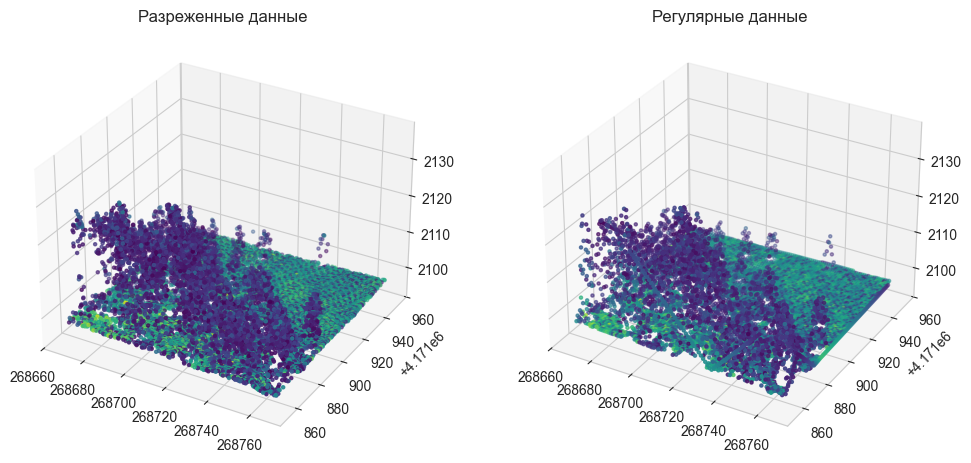

In [25]:
# Извлечем координаты точек и интенсивность
points = np.vstack((las.x, las.y, las.z)).transpose()
intensity = las.intensity

# Функция для уменьшения плотности точек
def reduce_points(points, factor):
    return points[::factor]

# Уменьшим плотность точек (каждая nth точка)
factor = 5
reduced_points = reduce_points(points, factor)
reduced_intensity = reduce_points(intensity, factor)

# Создать регулярную сетку
grid_x, grid_y = np.mgrid[points[:,0].min():points[:,0].max():100j, points[:,1].min():points[:,1].max():100j]

# Интерполяция для получения z координат на регулярной сетке
grid_z = griddata(points[:, 0:2], points[:, 2], (grid_x, grid_y), method='linear')

# Для интенсивности можно использовать такую же интерполяцию
grid_intensity = griddata(points[:, 0:2], intensity, (grid_x, grid_y), method='linear')

# Теперь у нас есть регулярные данные
regular_points = np.vstack((grid_x.ravel(), grid_y.ravel(), grid_z.ravel())).transpose()
regular_intensity = grid_intensity.ravel()

print(f'До разреживания: {len(points)} точек')
print(f'После разреживания: {len(reduced_points)} точек')
print(f'Регулярные точки: {len(regular_points)} точек')

# Визуализация разреженных данных
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(reduced_points[:, 0], reduced_points[:, 1], reduced_points[:, 2], c=reduced_intensity, cmap='viridis', marker='.')
ax.set_title("Разреженные данные")

# Визуализация регулярных данных
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(regular_points[:, 0], regular_points[:, 1], regular_points[:, 2], c=regular_intensity, cmap='viridis', marker='.')
ax2.set_title("Регулярные данные")

plt.show()

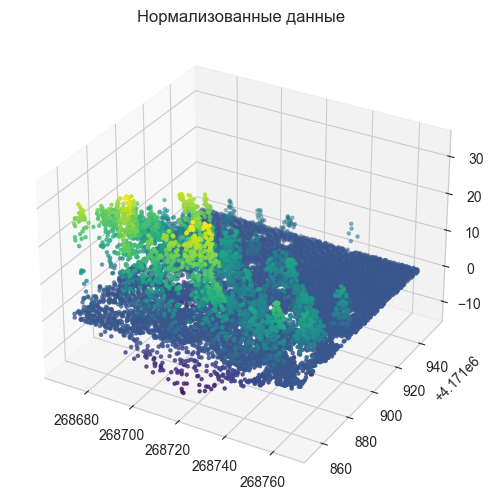

In [26]:
def segment_ground(points, cell_size=1.0, slope_threshold=1.0, elevation_threshold=0.5):
    x_min, x_max = np.min(points[:,0]), np.max(points[:,0])
    y_min, y_max = np.min(points[:,1]), np.max(points[:,1])
    
    grid_x, grid_y = np.mgrid[x_min:x_max:cell_size, y_min:y_max:cell_size]
    
    flat_points = points[:, :2]
    heights = points[:, 2]
    
    grid_heights = griddata(flat_points, heights, (grid_x, grid_y), method='linear')
    
    ground_mask = np.zeros_like(grid_heights, dtype=bool)
    
    def slope(p1, p2):
        p1 = np.array(p1)
        p2 = np.array(p2)
        return (p2[2] - p1[2]) / np.linalg.norm(p2[0:2] - p1[0:2])
    
    for i in range(grid_heights.shape[0]):
        for j in range(grid_heights.shape[1]):
            if np.isnan(grid_heights[i, j]):
                continue
            if i > 0 and np.abs(slope([i, j, grid_heights[i, j]], [i-1, j, grid_heights[i-1, j]])) > slope_threshold:
                continue
            if j > 0 and np.abs(slope([i, j, grid_heights[i, j]], [i, j-1, grid_heights[i, j-1]])) > slope_threshold:
                continue
            if i < grid_heights.shape[0] - 1 and np.abs(slope([i, j, grid_heights[i, j]], [i+1, j, grid_heights[i+1, j]])) > slope_threshold:
                continue
            if j < grid_heights.shape[1] - 1 and np.abs(slope([i, j, grid_heights[i, j]], [i, j+1, grid_heights[i, j+1]])) > slope_threshold:
                continue
            ground_mask[i, j] = True
    
    ground_points = []
    for i in range(grid_heights.shape[0]):
        for j in range(grid_heights.shape[1]):
            if ground_mask[i, j]:
                ground_points.append([grid_x[i, j], grid_y[i, j], grid_heights[i, j]])
    
    return np.array(ground_points)

# Функция для нормализации высот точек
def normalize_heights(points, ground_points):
    interpolated_ground_heights = griddata(ground_points[:, :2], ground_points[:, 2], (points[:, 0], points[:, 1]), method='linear')
    normalized_heights = points[:, 2] - interpolated_ground_heights
    return normalized_heights

# Функция группового суммирования для удаления дубликатов
def group_and_sum(points, normalized_heights):
    unique_points = {}
    for point, height in zip(points, normalized_heights):
        xy = (point[0], point[1])
        if xy in unique_points:
            unique_points[xy].append(height)
        else:
            unique_points[xy] = [height]
    
    grouped_points = []
    grouped_heights = []
    for xy, heights in unique_points.items():
        grouped_points.append([xy[0], xy[1], np.mean(heights)])
        grouped_heights.append(np.mean(heights))
    
    return np.array(grouped_points), np.array(grouped_heights)


# Сегментируем поверхность для выделения земли
ground_points = segment_ground(reduced_points)

# Нормализуем высоты точек
normalized_heights = normalize_heights(reduced_points, ground_points)

# Групповое суммирование точек для устранения дубликатов
grouped_points, grouped_heights = group_and_sum(reduced_points, normalized_heights)

# Визуализация нормализованных данных
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_points[:, 0], grouped_points[:, 1], grouped_heights, c=grouped_heights, cmap='viridis', marker='.')
ax.set_title("Нормализованные данные")
plt.show()



Осталось точек после фильтрации: 8247


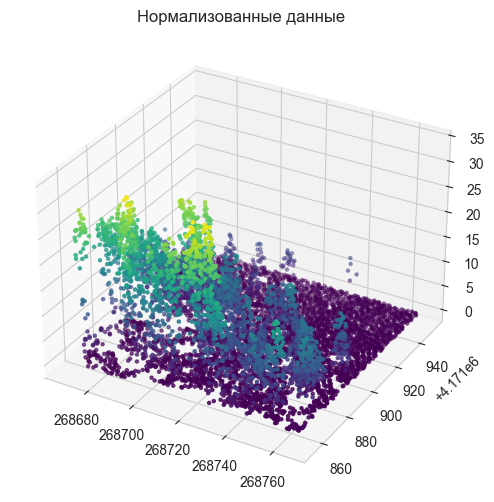

In [27]:
# Фильтрация точек с высотой >= 0 и приведение высоты к int32
filtered_points = grouped_points[grouped_heights >= 0]
filtered_heights = grouped_heights[grouped_heights >= 0]

print(f'Осталось точек после фильтрации: {len(filtered_points)}')

# Визуализация нормализованных данных
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_points[:, 0], filtered_points[:, 1], filtered_heights, c=filtered_heights, cmap='viridis', marker='.')
ax.set_title("Нормализованные данные")
plt.show()

# Запись нормализованных данных обратно в LAS файл
output_file_path = 'data2_normalized.las'
header = las.header
new_las = pylas.create()
new_las.x = filtered_points[:, 0]
new_las.y = filtered_points[:, 1]
new_las.z = filtered_heights
new_las.intensity = intensity[:len(filtered_points)]  # Отделка интенсивности, если требуется
new_las.write(output_file_path)

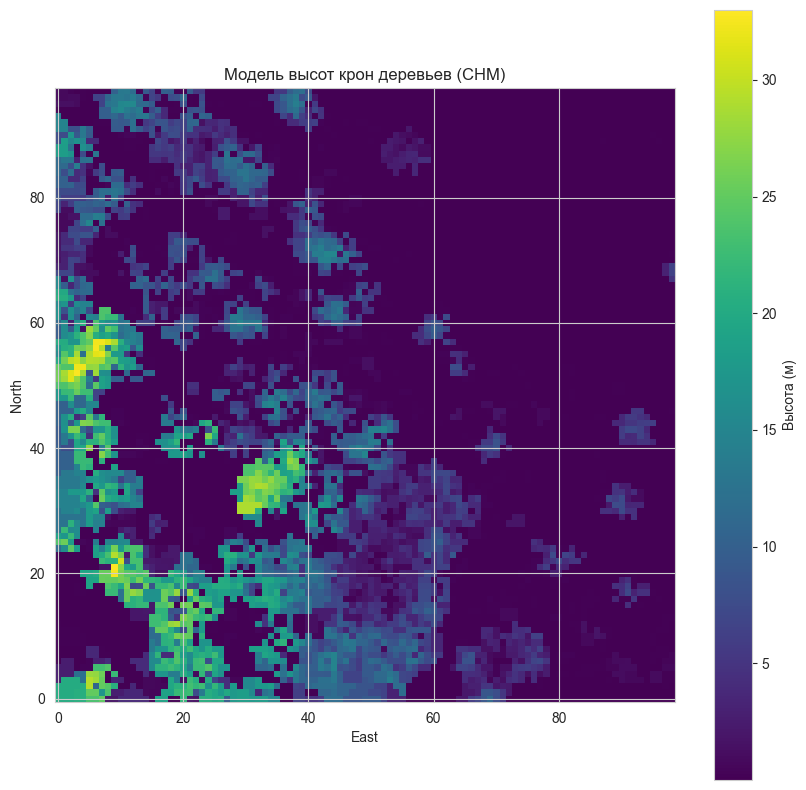

In [28]:
# Подготовим сетку для создания CHM
grid_size = 1.0  # Размер сетки 1x1 метра
x_min, x_max = filtered_points[:, 0].min(), filtered_points[:, 0].max()
y_min, y_max = filtered_points[:, 1].min(), filtered_points[:, 1].max()

grid_x, grid_y = np.mgrid[x_min:x_max:grid_size, y_min:y_max:grid_size]

# Интерполяция высот для создания CHM
chm = griddata(filtered_points[:, :2], filtered_points[:, 2], (grid_x, grid_y), method='nearest')

plt.figure(figsize=(10, 10))
plt.imshow(chm, cmap='viridis', origin='lower')
plt.colorbar(label='Высота (м)')
plt.title('Модель высот крон деревьев (CHM)')
plt.xlabel('East')
plt.ylabel('North')
plt.show()


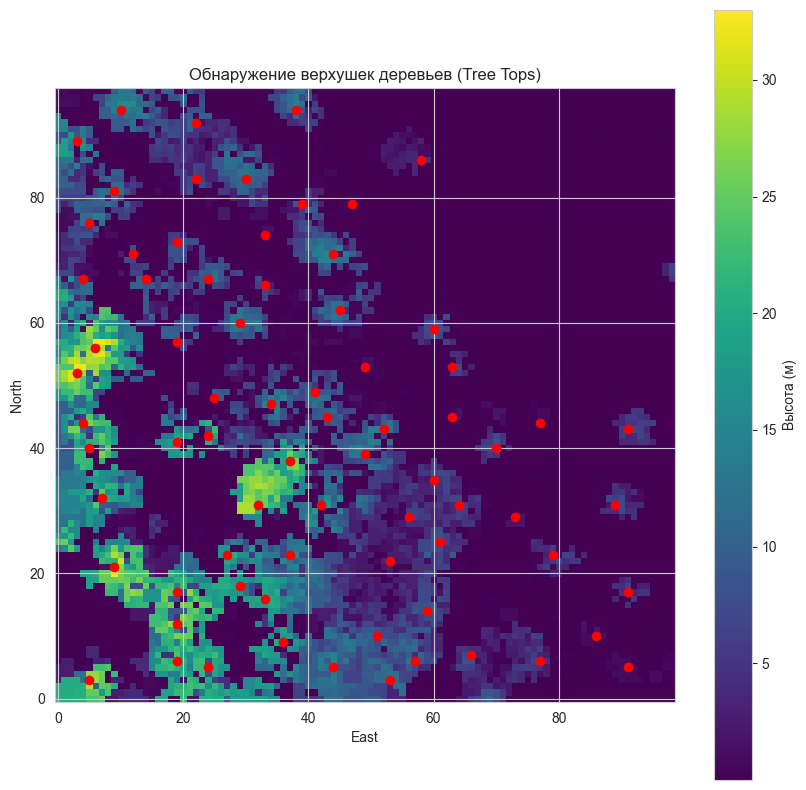

In [18]:
# Установим минимальную высоту дерева
minTreeHeight = 0.5  # Минимальная высота дерева в метрах

# Обнаружение верхушек деревьев
footprint_size = 3 # Размер окна для поиска вершин дерева

# Обнаружение верхушек деревьев
tree_tops = peak_local_max(chm, min_distance=footprint_size, threshold_abs=minTreeHeight, labels=chm > minTreeHeight)

plt.figure(figsize=(10, 10))
plt.imshow(chm, cmap='viridis', origin='lower')
plt.colorbar(label='Высота (м)')
plt.title('Обнаружение верхушек деревьев (Tree Tops)')
plt.xlabel('East')
plt.ylabel('North')
plt.plot(tree_tops[:, 1], tree_tops[:, 0], 'ro')
plt.show()

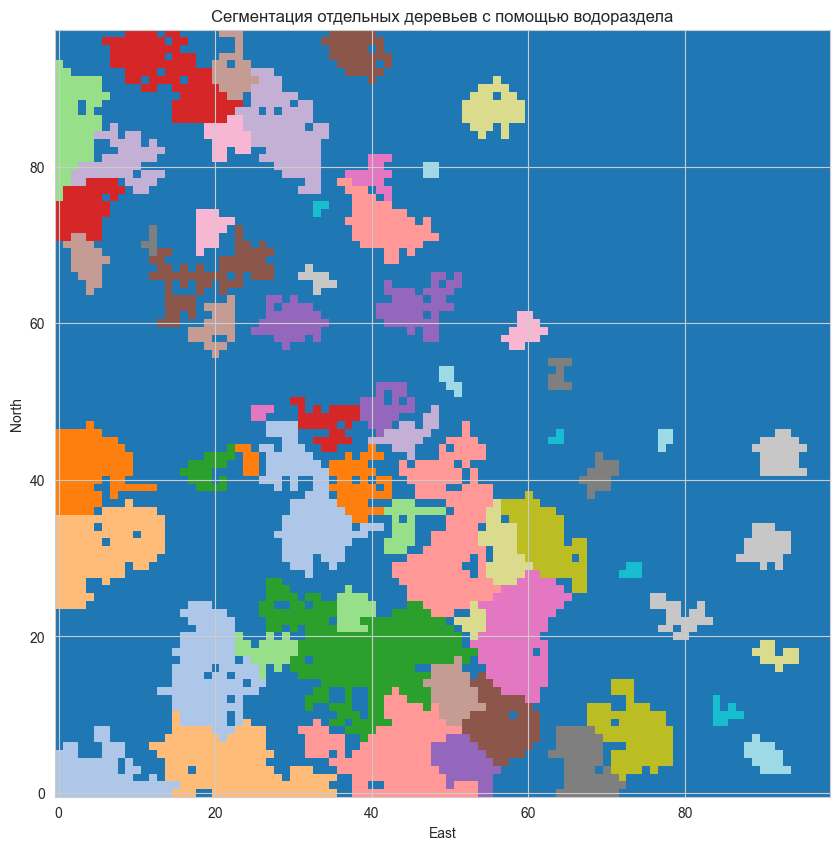

In [19]:
# Создадим маркеры для сегментации водораздела
markers = np.zeros_like(chm, dtype=int)
markers[tree_tops[:, 0], tree_tops[:, 1]] = np.arange(1, len(tree_tops) + 1)

# Сегментация водораздела
segments = watershed(-chm, markers, mask=chm > minTreeHeight)

plt.figure(figsize=(10, 10))
plt.imshow(segments, cmap='tab20', origin='lower')
plt.title('Сегментация отдельных деревьев с помощью водораздела')
plt.xlabel('East')
plt.ylabel('North')
plt.show()

    Tree ID  Top X  Top Y     Height  Crown Area
0         1     21      9  32.992394       107.0
1         2     52      3  32.830155        92.0
2         3     56      6  32.511754       108.0
3         4      2      5  29.284914        76.0
4         5     31     32  29.073519       124.0
..      ...    ...    ...        ...         ...
69       70     74     33   1.531283         3.0
70       71     53     49   1.303665         7.0
71       72      5     91   1.048138        18.0
72       73     44     77   0.787513         5.0
73       74     79     47   0.611332         4.0

[74 rows x 5 columns]


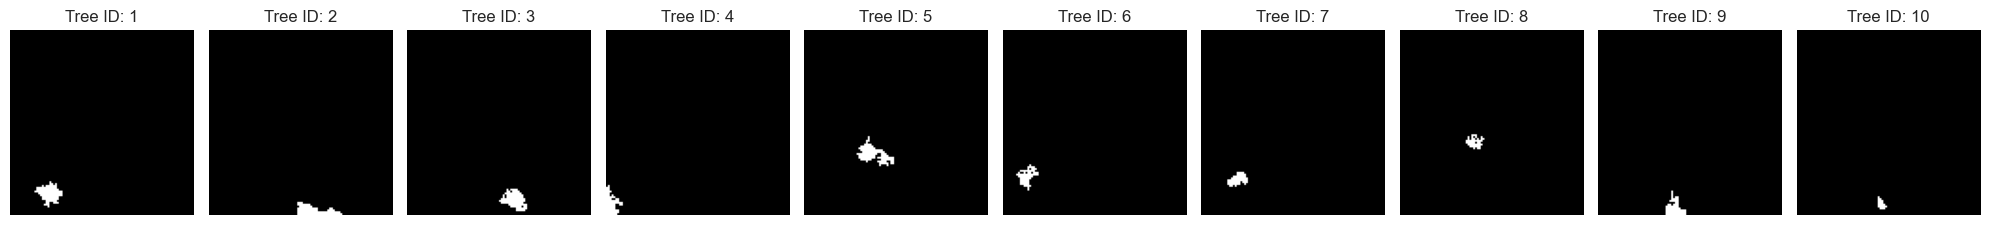

In [20]:

# Вспомогательная функция для вычисления атрибутов дерева
def compute_tree_metrics(segments, chm):
    trees = np.unique(segments)[1:]  # Исключаем нулевой сегмент (фон)
    tree_metrics = []

    for tree in trees:
        tree_mask = segments == tree
        tree_points = np.vstack(np.nonzero(tree_mask)).T

        if len(tree_points) == 0:
            continue

        x_coords, y_coords = tree_points[:, 0], tree_points[:, 1]
        heights = chm[x_coords, y_coords]

        tree_top_idx = np.argmax(heights)
        tree_top = (x_coords[tree_top_idx], y_coords[tree_top_idx])

        metrics = {
            'Tree ID': tree,
            'Top X': tree_top[0],
            'Top Y': tree_top[1],
            'Height': heights[tree_top_idx],
            'Crown Area': np.sum(tree_mask) * grid_size**2
        }

        tree_metrics.append(metrics)

    return tree_metrics

# Вычислим атрибуты деревьев
tree_metrics = compute_tree_metrics(segments, chm)

# Сохраним атрибуты деревьев в таблицу
tree_metrics_df = pd.DataFrame(tree_metrics)
print(tree_metrics_df)

# Визуализация отдельных деревьев (первые несколько деревьев)
n_trees_to_plot = 10
unique_trees = np.unique(segments)

fig, axes = plt.subplots(1, n_trees_to_plot, figsize=(20, 5))
for i, tree_id in enumerate(unique_trees[1:n_trees_to_plot+1]):
    tree_mask = segments == tree_id
    axes[i].imshow(tree_mask.T, cmap='gray', origin='lower')
    axes[i].set_title(f'Tree ID: {tree_id}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Количество деревьев: 16
Количество кустарников: 31
Количество трав: 27
Всего объектов: 74


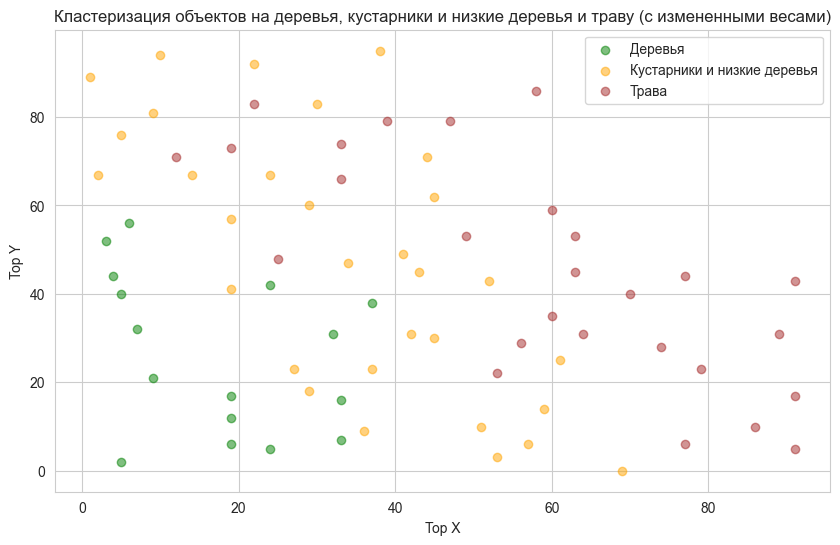

    Tree ID  Top X  Top Y     Height  Crown Area  Cluster
0         1     21      9  32.992394       107.0        2
1         2     52      3  32.830155        92.0        2
2         3     56      6  32.511754       108.0        2
3         4      2      5  29.284914        76.0        2
4         5     31     32  29.073519       124.0        2
..      ...    ...    ...        ...         ...      ...
69       70     74     33   1.531283         3.0        1
70       71     53     49   1.303665         7.0        1
71       72      5     91   1.048138        18.0        1
72       73     44     77   0.787513         5.0        1
73       74     79     47   0.611332         4.0        1

[74 rows x 6 columns]


In [21]:
# Подготовка данных для кластеризации с манипуляцией весами характеристик
scaling_factors = {'Height': 1.25, 'Crown Area': 0.75}  # Увеличиваем вес высоты и уменьшаем вес других характеристик

# Нормализация данных перед применением масштабирования
scaler = StandardScaler()

# Отдельное нормализирование каждого признака и их масштабирование
features_scaled = pd.DataFrame(scaler.fit_transform(tree_metrics_df[['Height','Crown Area']]),
                               columns=['Height', 'Crown Area'])
for col in scaling_factors:
    features_scaled[col] *= scaling_factors[col]

# Кластеризация с использованием K-Means на 3 кластера (деревья, кустарники, трава)
kmeans = KMeans(n_clusters=3, random_state=0).fit(features_scaled)
tree_metrics_df['Cluster'] = kmeans.labels_

# Определим, какие кластеры относятся к деревьям, кустарникам и траве
cluster_centers = kmeans.cluster_centers_

tree_cluster = np.argmax(cluster_centers[:, 0])  # Самый высокий кластер
grass_cluster = np.argmin(cluster_centers[:, 0])  # Самый низкий кластер
shrub_cluster = list(set(range(3)) - {tree_cluster, grass_cluster})[0]  # Остальной кластер - кустарники

# Выделим объекты, принадлежащие к деревьям, кустарникам и траве
trees = tree_metrics_df[tree_metrics_df['Cluster'] == tree_cluster]
shrubs = tree_metrics_df[tree_metrics_df['Cluster'] == shrub_cluster]
grass = tree_metrics_df[tree_metrics_df['Cluster'] == grass_cluster]

# Подсчет объектов каждого типа
num_trees = len(tree_metrics_df[tree_metrics_df['Cluster'] == tree_cluster])
num_shrubs = len(tree_metrics_df[tree_metrics_df['Cluster'] == shrub_cluster])
num_grass = len(tree_metrics_df[tree_metrics_df['Cluster'] == grass_cluster])

print(f"Количество деревьев: {num_trees}")
print(f"Количество кустарников: {num_shrubs}")
print(f"Количество трав: {num_grass}")
print(f"Всего объектов: {num_grass + num_shrubs + num_trees}") 


# Визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(trees['Top Y'], trees['Top X'], c='green', label='Деревья', alpha=0.5)
plt.scatter(shrubs['Top Y'], shrubs['Top X'], c='orange', label='Кустарники и низкие деревья', alpha=0.5)
plt.scatter(grass['Top Y'], grass['Top X'], c='brown', label='Трава', alpha=0.5)
plt.title('Кластеризация объектов на деревья, кустарники и низкие деревья и траву (с измененными весами)')
plt.xlabel('Top X')
plt.ylabel('Top Y')
plt.legend()
plt.show()

# Удаление прочих объектов (оставлю только деревья, кустарники и траву)
filtered_metrics_df = pd.concat([trees, shrubs, grass])

# Выводим результирующую таблицу
print(filtered_metrics_df)

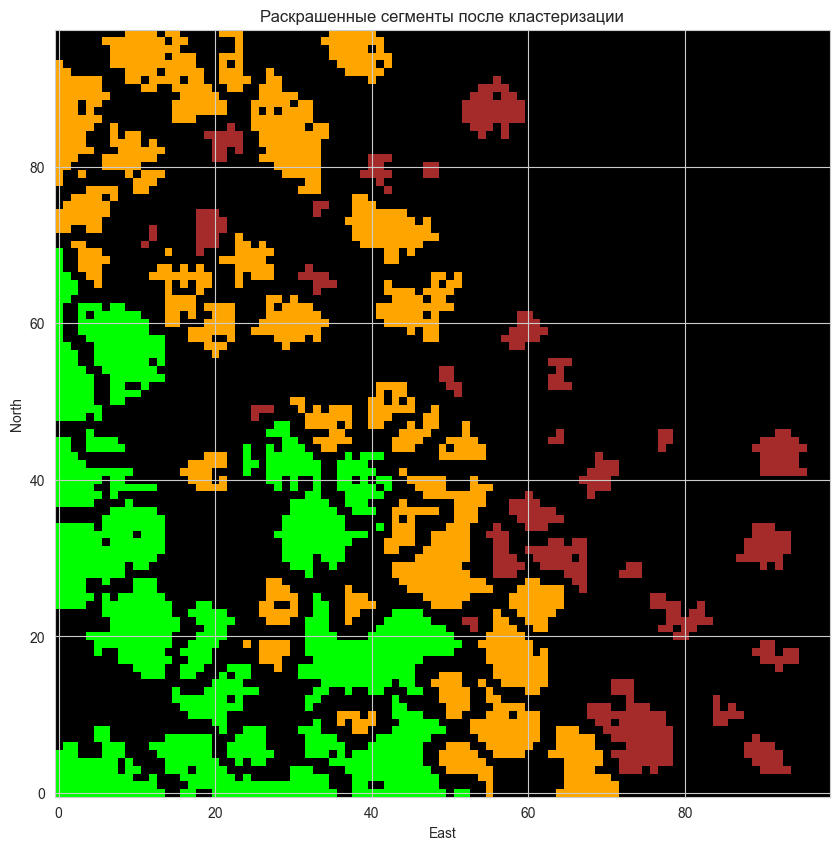

    Tree ID  Top X  Top Y     Height  Crown Area  Cluster
0         1     21      9  32.992394       107.0        2
1         2     52      3  32.830155        92.0        2
2         3     56      6  32.511754       108.0        2
3         4      2      5  29.284914        76.0        2
4         5     31     32  29.073519       124.0        2
..      ...    ...    ...        ...         ...      ...
69       70     74     33   1.531283         3.0        1
70       71     53     49   1.303665         7.0        1
71       72      5     91   1.048138        18.0        1
72       73     44     77   0.787513         5.0        1
73       74     79     47   0.611332         4.0        1

[74 rows x 6 columns]


In [22]:
# Назначим цвета для каждого кластера
cluster_colors = {tree_cluster: (0, 255, 0), shrub_cluster: (255, 165, 0), grass_cluster: (165, 42, 42)}  # RGB

# Функция для назначения цвета сегментам
def assign_color_to_segments(segments, tree_metrics_df, cluster_colors):
    color_segment_map = np.zeros((*segments.shape, 3), dtype=np.uint8)  # Массив для цветов в формате RGB
    
    for idx, row in tree_metrics_df.iterrows():
        tree_id = row['Tree ID']
        cluster = row['Cluster']
        color = cluster_colors[cluster]
        
        tree_segment_mask = segments == tree_id
        color_segment_map[tree_segment_mask] = color
    
    return color_segment_map

# Применение кластеров к сегментированному изображению
colorized_segments = assign_color_to_segments(segments, tree_metrics_df, cluster_colors)

# Определим границы сегментов
boundaries = find_boundaries(segments, mode='outer')
colorized_segments[boundaries] = [0, 0, 0]  # Добавляем черные границы

# Визуализация раскрашенных сегментов
plt.figure(figsize=(10, 10))
plt.imshow(colorized_segments, origin='lower')
plt.title('Раскрашенные сегменты после кластеризации')
plt.xlabel('East')
plt.ylabel('North')
plt.show()

# Выводим результирующую таблицу
filtered_metrics_df = tree_metrics_df[tree_metrics_df['Cluster'].isin([tree_cluster, shrub_cluster, grass_cluster])]
print(filtered_metrics_df)

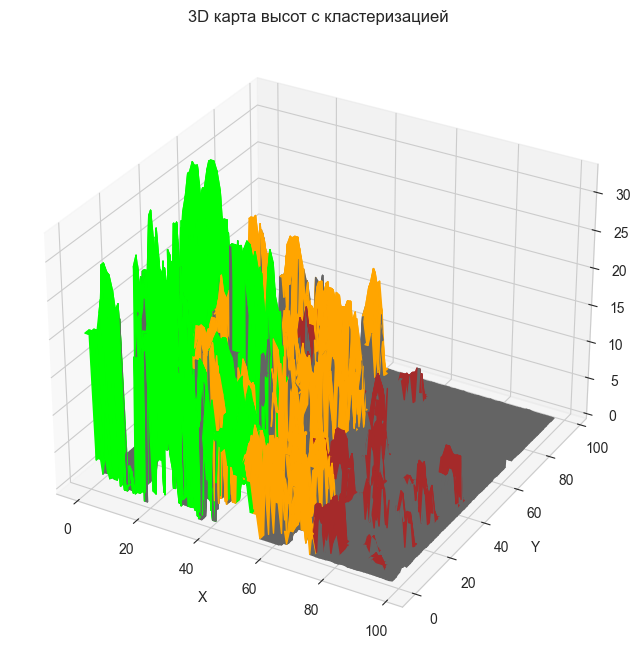

    Tree ID  Top X  Top Y     Height  Crown Area  Cluster
0         1     21      9  32.992394       107.0        2
1         2     52      3  32.830155        92.0        2
2         3     56      6  32.511754       108.0        2
3         4      2      5  29.284914        76.0        2
4         5     31     32  29.073519       124.0        2
..      ...    ...    ...        ...         ...      ...
69       70     74     33   1.531283         3.0        1
70       71     53     49   1.303665         7.0        1
71       72      5     91   1.048138        18.0        1
72       73     44     77   0.787513         5.0        1
73       74     79     47   0.611332         4.0        1

[74 rows x 6 columns]


In [23]:
# Создание 3D карты высот
colored_chm = np.zeros((chm.shape[0], chm.shape[1], 3), dtype=np.uint8)

for (x, y), height in np.ndenumerate(chm):
    segment_label = segments[x, y]
    if segment_label == 0:
        colored_chm[x, y] = [100, 100, 100]  # Серый цвет для поверхности
    else:
        cluster = tree_metrics_df.loc[tree_metrics_df['Tree ID'] == segment_label, 'Cluster'].values[0]
        colored_chm[x, y] = cluster_colors[cluster]

# Визуализация 3D карты высот с помощью matplotlib
X, Y = np.meshgrid(np.arange(chm.shape[1]), np.arange(chm.shape[0]))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, chm, facecolors=colored_chm/255, rstride=1, cstride=1, shade=False)
ax.set_title('3D карта высот с кластеризацией')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
plt.show()

# Визуализация 3D карты высот с помощью plotly
fig = go.Figure(data=[go.Surface(z=chm, surfacecolor=np.dot(colored_chm[...,:3], [0.2989, 0.5870, 0.1140]))])
fig.update_layout(title='3D карта высот с кластеризацией', autosize=False,
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Height'),
                  width=800, height=800)
fig.show()

# Выводим результирующую таблицу
filtered_metrics_df = tree_metrics_df[tree_metrics_df['Cluster'].isin([tree_cluster, shrub_cluster, grass_cluster])]
print(filtered_metrics_df)

In [24]:
end_time = time.time()

# Подсчет времени выполнения
execution_time = end_time - start_time

print(f"Время выполнения алгоритма: {execution_time:.2f} секунд")

Время выполнения алгоритма: 8.65 секунд
